In [3]:
import argparse
import csv
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.interpolate import CubicSpline

from drdmannturb.Calibration import CalibrationProblem
from drdmannturb.common import MannEddyLifetime
from drdmannturb.DataGenerator import OnePointSpectraDataGenerator

plt.style.use("bmh")

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

savedir = Path().resolve().parent / "results"

In [9]:
CONSTANTS_CONFIG = {
    "type_EddyLifetime": "customMLP",
    "type_PowerSpectra": "RDT",
    "learn_nu": False,
    "plt_tau": True,
    "hlayers": [10, 10],
    "tol": 1.0e-9,
    "lr": 1,
    "penalty": 1,
    "regularization": 1.0e-5,
    "nepochs": 10,
    "curves": [0, 1, 2, 3],
    "data_type": "Auto",  # Custom
    "spectra_file": Path().resolve().parent / "data" / "Spectra_interp.dat",
    "Uref": 21,
    # "zref": 1,
    "zref": 80,
    "domain": torch.logspace(
        -1, 2, 20
    ),  # NOTE: This gets updated in the script portion
    "noisy_data": 0.0,
    "output_folder": str(savedir),
}

zref = CONSTANTS_CONFIG["zref"]
Uref = CONSTANTS_CONFIG["Uref"]
Iref = 0.14
sigma1 = Iref * (0.75 * Uref + 5.6)
Lambda1 = 42

z0 = 0.01
ustar = 0.41 * Uref / np.log(zref / z0)

L = 70
GAMMA = 3.7
SIGMA = 0.04

[ReLU(), ReLU(), ReLU(), ReLU()]
READING FILE /home/ai/Documents/wind/DRDMannTurb/experiments/data/Spectra_interp.dat


Reading file /home/ai/Documents/wind/DRDMannTurb/experiments/data/Spectra_interp.dat

[fit1] ---------------------
Parameters [42.66723904 15.55803923  1.54783646]
RMSE: 0.031004330920975764
R-squared: 0.9923919996428556
[fit2] ---------------------
Parameters [7.15090096 5.14328432 1.46249936]
RMSE: 0.06520305140278539
R-squared: 0.8459555462305597
[fit3] ---------------------
Parameters [1.01749967 0.79402232 1.82200663]
RMSE: 0.021837277467692644
R-squared: 0.9616523792867717
[fit4] ---------------------
Parameters [ 3.01931414 27.78937149  1.73358938]
RMSE: 0.03334878094620613
R-squared: 0.8536573461049848
DataValues is on 0

Calibrating MannNet...
torch.Size([156])
Initial loss:  95.48764816881234

[Calibration.py -- calibrate]-> Epoch 0

loss  =  95.48778805438768
loss  =  77.64547508963659
loss  =  7.869292542648913
loss  =  3.3127072508114557
loss  =  2.564380

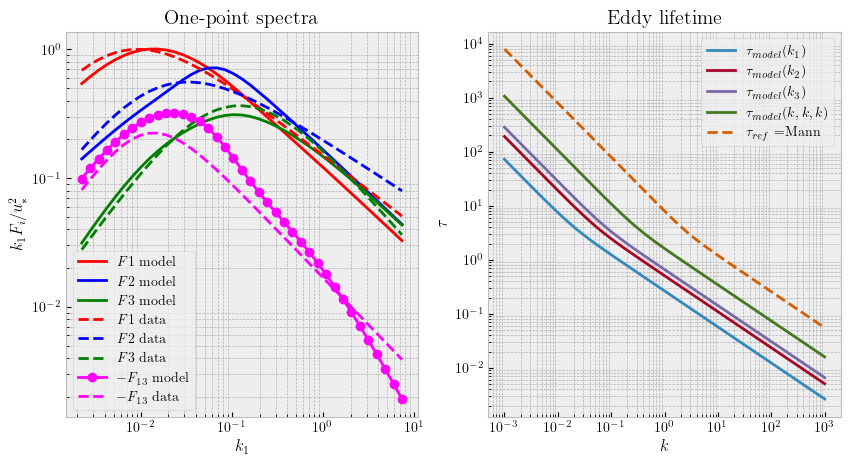

In [10]:
config = CONSTANTS_CONFIG
config["activations"] = [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()]
config["hlayers"] = [32] * 4
config["wolfe_iter"] = 10

pb = CalibrationProblem(**config)
parameters = pb.parameters
parameters[:3] = [np.log(L), np.log(GAMMA), np.log(SIGMA)]

pb.parameters = parameters[: len(pb.parameters)]

k1_data_pts = config["domain"]
spectra_file = config["spectra_file"]
print(f"READING FILE {spectra_file}\n\n")
CustomData = torch.tensor(np.genfromtxt(spectra_file, skip_header=1, delimiter=","))
f = CustomData[:, 0]
k1_data_pts = 2 * torch.pi * f / Uref

DataPoints = [(k1, 1) for k1 in k1_data_pts]
Data = OnePointSpectraDataGenerator(
    DataPoints=DataPoints,
    k1_data_points=k1_data_pts.cpu().detach().numpy(),
    **config,
).Data

DataValues = Data[1]

IECtau = MannEddyLifetime(k1_data_pts * L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **config)

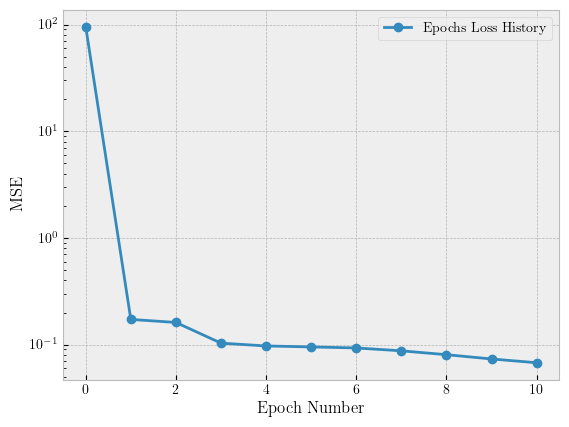

In [11]:
plt.figure()

plt.plot(pb.loss_history_epochs, "o-", label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale("log")

Text(0, 0.5, '$L^1$ Size')

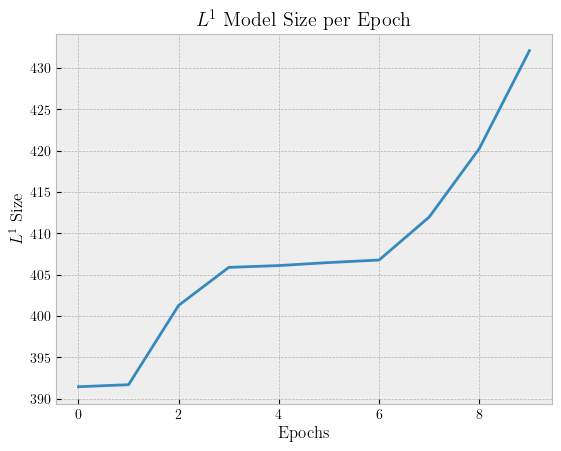

In [13]:
plt.figure() 
plt.title(r"$L^1$ Model Size per Epoch")
plt.plot([x.detach().cpu().numpy() for x in pb.epoch_model_sizes])

plt.xlabel("Epochs")
plt.ylabel(r"$L^1$ Size")